### Week 4 Homework 2025

In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [34]:
data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
data.head().T

,0,1,2,3,4
lead_source,paid_ads,social_media,events,paid_ads,referral
industry,NaN,retail,healthcare,retail,education
number_of_courses_viewed,1,1,5,2,3
annual_income,79450.0,46992.0,78796.0,83843.0,85012.0
employment_status,unemployed,employed,unemployed,NaN,self_employed
location,south_america,south_america,australia,australia,europe
interaction_count,4,1,3,1,3
lead_score,0.94,0.8,0.69,0.87,0.62
converted,1,0,1,0,1


In [35]:
data.describe()

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
count,1462.000000,1281.000000,1462.000000,1462.000000,1462.000000
mean,2.031464,59886.273224,2.976744,0.506108,0.619015
std,1.449717,15070.140389,1.681564,0.288465,0.485795
min,0.000000,13929.000000,0.000000,0.000000,0.000000
25%,1.000000,49698.000000,2.000000,0.262500,0.000000
50%,2.000000,60148.000000,3.000000,0.510000,1.000000
75%,3.000000,69639.000000,4.000000,0.750000,1.000000
max,9.000000,109899.000000,11.000000,1.000000,1.000000


In [36]:
data.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [37]:
data.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [38]:
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

categorical = ['lead_source', 'industry', 'employment_status', 'location']

In [39]:
for c in categorical:
    data[c] = data[c].fillna('NA')

In [40]:
data['annual_income'] = data['annual_income'].fillna(0)

In [41]:
data.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


### Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

In [42]:
from sklearn.metrics import roc_auc_score

In [43]:
df_full_train, df_test = train_test_split(data, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

assert 'converted' not in df_train
assert 'converted' not in df_val
assert 'converted' not in df_test

In [44]:
results = {}
for col in numerical:
    # Use the numerical column as prediction scores
    scores = df_train[col]
    
    # Calculate AUC
    auc = roc_auc_score(y_train, scores)
    
    # If AUC < 0.5, use negative values
    if auc < 0.5:
        scores = -df_train[col]
        auc = roc_auc_score(y_train, scores)
    
    results[col] = auc

# Display results
for feature, auc in results.items():
    print(f"{feature}: {auc:.4f}")

# Find the highest AUC
highest_feature = max(results, key=results.get)
print(f"\nHighest AUC: {highest_feature} ({results[highest_feature]:.4f})")

number_of_courses_viewed: 0.7636
annual_income: 0.5520
interaction_count: 0.7383
lead_score: 0.6145

Highest AUC: number_of_courses_viewed (0.7636)


__number_of_courses_viewed__ has the highest AUC among the four numerical features.

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [51]:
dv = DictVectorizer(sparse = False)
train_dict = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [52]:
val_dict = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.817


The AUC score for the dataset using the instruction is 0.817.

#### Using StandardScaler

In [59]:
from sklearn.preprocessing import StandardScaler

In [60]:
X_train_num = df_train[numerical].values

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train_num)

In [61]:
dv = DictVectorizer(sparse = False)
train_dict = df_train[categorical].to_dict(orient = 'records')
X_train_cat = dv.fit_transform(train_dict)
X_train = np.column_stack([X_train_num, X_train_cat])

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [62]:
X_val_num = df_val[numerical].values
X_val_num = scaler.transform(X_val_num)

val_dict = df_val[categorical].to_dict(orient = 'records')
X_val_cat = dv.transform(val_dict)

X_val = np.column_stack([X_val_num, X_val_cat])

In [63]:
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

print(f"Validation AUC: {auc:.3f}")

Validation AUC: 0.921


The AUC of this model on the validation dataset using StandardScaler is 0.92.

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

In [75]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0,1,100)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >=t)
        predict_negative = (y_pred < t)
        
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        scores.append((t,tp,fp,fn,tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)

    return df_scores

In [76]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores

,threshold,tp,fp,fn,tn
0,0.000000,171,122,0,0
1,0.010101,171,116,0,6
2,0.020202,171,110,0,12
3,0.030303,170,108,1,14
4,0.040404,170,103,1,19
...,...,...,...,...,...
95,0.959596,66,2,105,120
96,0.969697,61,0,110,122
97,0.979798,51,0,120,122
98,0.989899,39,0,132,122


In [78]:
df_scores['recall'] = df_scores.tp / (df_scores.fn+ df_scores.tp)
df_scores['precision'] = df_scores.tp / (df_scores.tp+ df_scores.fp)

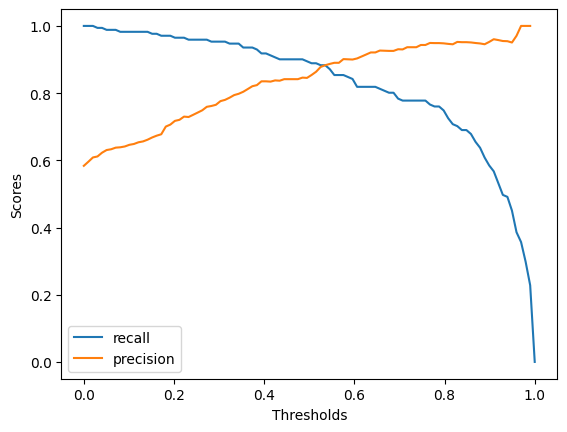

In [79]:
plt.plot(df_scores.threshold, df_scores['recall'], label="recall")
plt.plot(df_scores.threshold, df_scores['precision'], label = "precision")

plt.xlabel('Thresholds')
plt.ylabel('Scores')
plt.legend()

### Finding the intersection point of precision - recall

In [80]:
intersection_idx = np.argmin(np.abs(df_scores['recall'] - df_scores['precision']))
intersection_threshold = df_scores.threshold.iloc[intersection_idx]

intersection_threshold

np.float64(0.5353535353535354)

At 0.535 threshold, the precision and recall curves intersect.

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74


In [ ]:
F1 = 2 * ((precision * recall)/ (precision + recall))

In [84]:
df_scores['F1'] = 2 * ((df_scores.precision * df_scores.recall) / (df_scores.precision+ df_scores.recall))
# Find threshold with maximum F1
max_f1_threshold = df_scores.loc[df_scores.F1.idxmax(), 'threshold']
print(f"Threshold with max F1: {max_f1_threshold:.2f}")

Threshold with max F1: 0.54


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [87]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [91]:
def train(df_train, df_val, y):
    scaler = StandardScaler()  
    X_train_num = df_train[numerical].values
    X_train_num = scaler.fit_transform(X_train_num)
    
    dicts = df_train[categorical].to_dict(orient = 'records')
    dv = DictVectorizer(sparse = False)
    
    X_train_cat = dv.fit_transform(dicts)
    X_train = np.column_stack([X_train_num, X_train_cat])

    X_val_num = df_val[numerical].values
    X_val_num = scaler.transform(X_val_num)
    
    val_dict = df_val[categorical].to_dict(orient = 'records')
    X_val_cat = dv.transform(val_dict)
    
    X_val = np.column_stack([X_val_num, X_val_cat])
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y)

    return X_val, model

In [95]:
scores = []

kfold =  KFold(n_splits = 5, shuffle = True, random_state = 1)

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.converted.values
    y_val = df_val.converted.values

    X_val, model = train(df_train, df_val, y_train)
    y_pred = model.predict_proba(X_val)[:,1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

# Final results
print(f'Mean AUC: {np.mean(scores):.3f}')
print(f'Standard deviation: {np.std(scores):.3f}')

0it [00:00, ?it/s]

Mean AUC: 0.921
Standard deviation: 0.010


In [97]:
np.std(scores)

np.float64(0.010420632341836546)

In [103]:
columns = categorical + numerical

In [104]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred
     

In [105]:
#@ INITIALIZING KFOLD CROSS VALIDATION:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [106]:
def train(df_train, df_val, y, C):
    scaler = StandardScaler()  
    X_train_num = df_train[numerical].values
    X_train_num = scaler.fit_transform(X_train_num)
    
    dicts = df_train[categorical].to_dict(orient = 'records')
    dv = DictVectorizer(sparse = False)
    
    X_train_cat = dv.fit_transform(dicts)
    X_train = np.column_stack([X_train_num, X_train_cat])

    X_val_num = df_val[numerical].values
    X_val_num = scaler.transform(X_val_num)
    
    val_dict = df_val[categorical].to_dict(orient = 'records')
    X_val_cat = dv.transform(val_dict)
    
    X_val = np.column_stack([X_val_num, X_val_cat])
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y)

    return X_val, model

In [108]:
for C in tqdm([0.000001, 0.001, 1]):
    scores = []
    
    kfold =  KFold(n_splits = 5, shuffle = True, random_state = 1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        X_val, model = train(df_train, df_val, y_train, C)
        y_pred = model.predict_proba(X_val)[:,1]
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    # Final results
    print('C=%s % .3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
    print(f'Mean AUC: {np.mean(scores):.3f}')
    print(f'Standard deviation: {np.std(scores):.3f}')

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06  0.903 +- 0.013
Mean AUC: 0.903
Standard deviation: 0.013
C=0.001  0.905 +- 0.013
Mean AUC: 0.905
Standard deviation: 0.013
C=1  0.921 +- 0.010
Mean AUC: 0.921
Standard deviation: 0.010
